# Gaussian Mixture Modelling applied to Open Clusters

Using <i>Gaia</i> EDR3 data to get membership probabilities of stars in Messier 6

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt

# Read Files
from astropy.io import fits

# Make pretty plots!
from utils import cmd, scatter_mag

# Convenience functions
from utils import univariate_gaussian, multivariate_gaussian

In [2]:
plt.rcParams['figure.figsize'] = (6,6)

In [3]:
all_data = fits.getdata("data/M6.fits.gz")

In [4]:
good_stars = (~np.isnan(all_data['bp_rp'])) & (~np.isnan(all_data['phot_g_mean_mag'])) & (all_data['parallax_over_error']>10)

data = all_data[good_stars]

ra, dec, pmra, pmdec, plx = data['ra'], data['dec'], data['pmra'], data['pmdec'], data['parallax']

g, bp_rp, g_rp, bp_g = data['phot_g_mean_mag'], data['bp_rp'], data['g_rp'], data['bp_g']

(-20.0, 0.0)

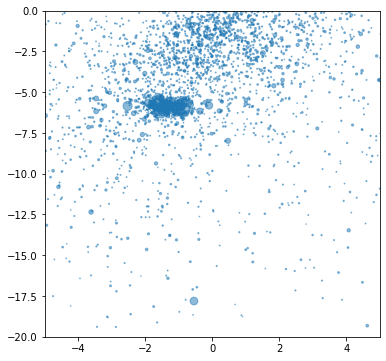

In [5]:
scatter_mag(pmra, pmdec, g, alpha=0.5)
plt.xlim(-5,5)
plt.ylim(-20,0)

**Initialization**

In [6]:
# Cluster
w_c = 0.5
mu_c = np.array([-2,-6])
Sigma_c = np.array([[0.1, 0], [0, 0.1]])

# Field
w_f = 1 - w_c
mu_f = np.array([0, -2.5])
Sigma_f = np.array([[400, 20], [20, 400]])

In [7]:
mu = np.c_[pmra, pmdec]

**Expectation**

In [8]:
pm_dist_c = w_c * multivariate_gaussian(mu, mu_c, Sigma_c)
pm_dist_f = w_f * multivariate_gaussian(mu, mu_f, Sigma_f) 
pm_dist = pm_dist_c + pm_dist_f

In [9]:
member_probability = pm_dist_c/pm_dist
field_probability = pm_dist_f/pm_dist

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


**Maximization**

Weights give the fraction of stars that belong to each class
$$ w_c = \frac{\sum_i^N p_c^{(i)}}{N}$$

Probability weighted mean
$$ \mu_c = \frac{\sum_i^N p_c^{(i)}\ \mu^{(i)}}{\sum_i^N p_c^{(i)}}$$

Probability weighted variance and coavariance
$$ \Sigma_c = \frac{\sum_i^N p_c^{(i)}\ (\mu^{(i)}-\mu_c)^T\cdot(\mu^{(i)}-\mu_c)}{\sum_i^N p_c^{(i)}}$$

In [10]:
w_c = np.sum(member_probability)/mu.shape[0]
mu_c = np.average(mu, weights=member_probability, axis=0)
Sigma_c = np.einsum('ji,ik->jk', member_probability*(mu-mu_c).T, mu-mu_c)/member_probability.sum()

In [11]:
w_f = np.sum(field_probability)/mu.shape[0]
mu_f = np.average(mu, weights=field_probability, axis=0)
Sigma_f = np.einsum('ji,ik->jk', field_probability*(mu-mu_f).T, mu-mu_f)/field_probability.sum()

In [12]:
mu_f

array([-1.04572803, -5.405016  ])

In [13]:
mu_c

array([-1.50674581, -5.87678428])

In [14]:
for i in range(50):
    pm_dist_c = w_c * multivariate_gaussian(mu, mu_c, Sigma_c)
    pm_dist_f = w_f * multivariate_gaussian(mu, mu_f, Sigma_f) 
    pm_dist = pm_dist_c + pm_dist_f

    member_probability = pm_dist_c/pm_dist
    field_probability = pm_dist_f/pm_dist

    w_c = np.sum(member_probability)/mu.shape[0]
    mu_c = np.average(mu, weights=member_probability, axis=0)
    Sigma_c = np.einsum('ji,ik->jk', member_probability*(mu-mu_c).T, mu-mu_c)/member_probability.sum()

    w_f = np.sum(field_probability)/mu.shape[0]
    mu_f = np.average(mu, weights=field_probability, axis=0)
    Sigma_f = np.einsum('ji,ik->jk', field_probability*(mu-mu_f).T, mu-mu_f)/field_probability.sum()

In [15]:
mu_f

array([-1.07226604, -5.40918585])

In [16]:
mu_c

array([-1.37917977, -5.84705984])

In [17]:
x,y = np.meshgrid(np.linspace(-50,50,100), np.linspace(-50,50,100))

In [18]:
mu_im = np.c_[x.flatten(), y.flatten()]

In [19]:
cluster_gaussian = multivariate_gaussian(mu_im, mu_c, Sigma_c)
field_gaussian = multivariate_gaussian(mu_im, mu_f, Sigma_f)

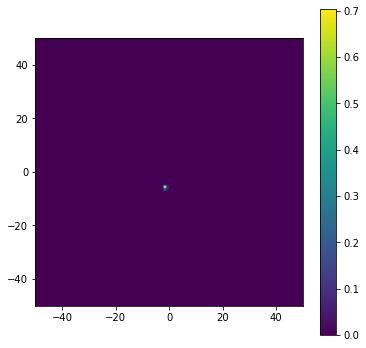

In [20]:
plt.imshow(cluster_gaussian.reshape(100,100), extent=(x.min(),x.max(),y.min(),y.max()), origin='lower')
plt.colorbar()

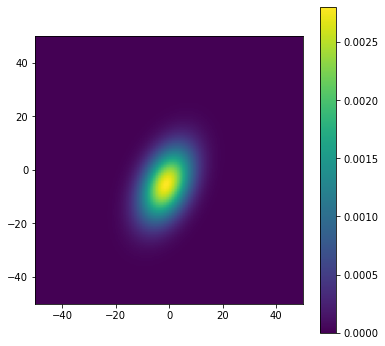

In [21]:
plt.imshow(field_gaussian.reshape(100,100), extent=(x.min(),x.max(),y.min(),y.max()), origin='lower')
plt.colorbar()

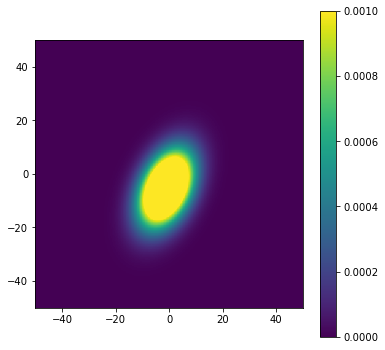

In [22]:
plt.imshow((w_c*cluster_gaussian+w_f*field_gaussian).reshape(100,100),
           extent=(x.min(),x.max(),y.min(),y.max()), origin='lower',
           vmin=0, 
           vmax=0.001
          )
plt.colorbar()
# plt.scatter(pmra[(np.abs(pmra)<50)&(np.abs(pmdec)<50)],
#             pmdec[(np.abs(pmra)<50)&(np.abs(pmdec)<50)],
#             color='w', s=0.1, alpha=0.5)

In [23]:
member_probability.sum()

696.2756653350248

In [24]:
mask = member_probability>0.9

In [25]:
mask.sum()

622

(-12.0, 0.0)

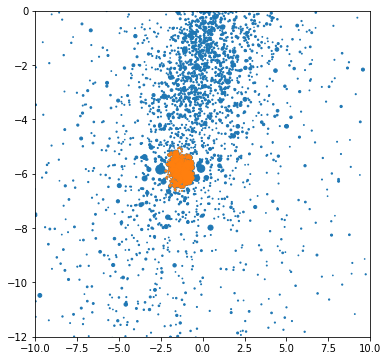

In [26]:
scatter_mag(pmra, pmdec,g)
scatter_mag(pmra[mask], pmdec[mask], g[mask])
plt.xlim(-10,10)
plt.ylim(-12,0)

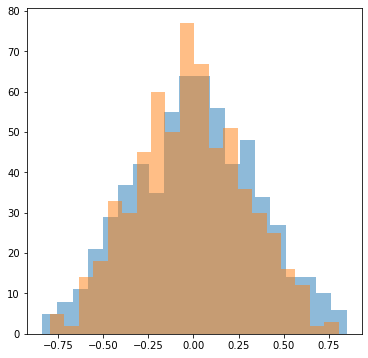

In [27]:
plt.hist(pmra[mask]-mu_c[0], bins=20, alpha=0.5);
plt.hist(pmdec[mask]-mu_c[1], bins=20, alpha=0.5);

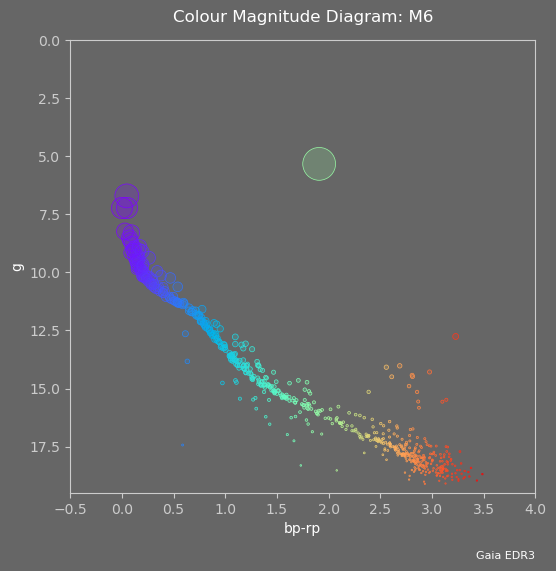

In [28]:
cmd(bp_rp[mask], g[mask], xlim=(-0.5, 4), ylim=(19.5, 0), col_name='bp-rp', name='M6')